# Seller Side Data Analysis

Olist’s marketing team have 2 main objectives:
- From the seller side, they want to increase the number of merchants using Olist platform.
- From the buyer side, they want to maximize the e-commerce sales of the merchants on these marketplaces.

The scope of this analysis focuses more on the seller side (B2B) of Olist that can bring some helpful insights into Olist’s B2B marketing team.

I am covering 3 subjects with data of the Brazilian ecommerce marketplace:  

**1) Marketing Channel Effectiveness**    
**2) Sales Performance Overview**    
**3) Closed Deal Performance Overview**


-----------

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
sns.set_style('whitegrid', {'grid.linestyle': '--'})
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

## 1. Marketing Channel Effectiveness

**Olist acquired sellers through diverse marketing channels.** Let's find out which channel was the most effective in lead generation. Below the term `Marketing Qualified Lead(MQL)` means a potential reseller/manufacturer who has an interest in selling their products on Olist.

In [2]:
mql = pd.read_csv('data/olist_marketing_qualified_leads_dataset.csv',
                  parse_dates=['first_contact_date'])

print(mql.shape)
mql.head(5)

(8000, 4)


,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


### Montly MQL volume

In [3]:
# Add a 'year-month' column
mql['first_contact_date(y-m)'] = mql['first_contact_date'].dt.to_period('M')

print(mql.shape)
mql[['first_contact_date', 'first_contact_date(y-m)']].head(3)

(8000, 5)


,first_contact_date,first_contact_date(y-m)
0,2018-02-01,2018-02
1,2017-10-20,2017-10
2,2018-03-22,2018-03


In [4]:
# Create time series table
monthly_mql = mql.groupby(by='first_contact_date(y-m)')['mql_id'].count()
monthly_mql.to_frame().T

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
mql_id,4,239,386,312,416,445,200,1141,1028,1174,1352,1303


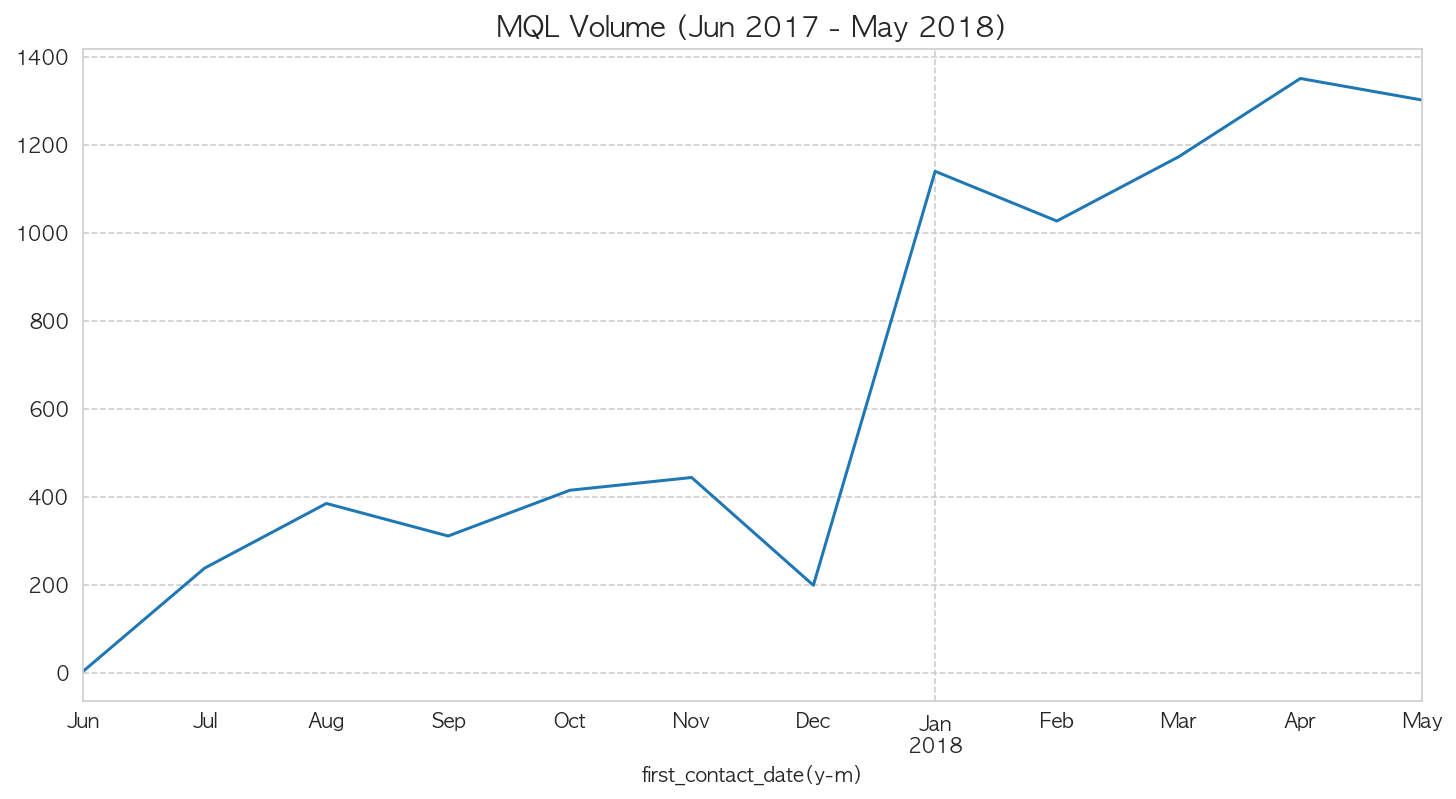

In [5]:
monthly_mql.plot.line(figsize=(12, 6))
plt.title('MQL Volume (Jun 2017 - May 2018)', fontsize=14);

Since 2018, monthly MQL volume soared to above 1,000.
MQL is significantly increased in 2018–01 and declined after that. This can be the result of a big event/PR campaign.

### MQL Volume by Marketing Channel

In [6]:
mql_origin = pd.pivot_table(mql,
                            index='origin',
                            columns='first_contact_date(y-m)',
                            values='mql_id',                            
                            aggfunc='count',
                            fill_value=0)
origin_list = mql.groupby('origin')['mql_id']\
                                   .count() \
                                   .sort_values(ascending=False) \
                                   .index

mql_origin = mql_origin.reindex(origin_list)
mql_origin


first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
origin,,,,,,,,,,,,
organic_search,0,54,122,78,125,121,60,412,291,340,349,344
paid_search,0,56,79,64,100,70,35,170,212,262,272,266
social,0,12,45,56,52,95,39,162,156,139,325,269
unknown,1,35,70,39,53,63,25,151,156,186,166,154
direct_traffic,0,16,22,22,23,26,10,82,65,80,75,78
email,1,19,24,23,30,37,12,61,68,74,50,94
referral,0,8,16,12,8,20,9,41,34,38,45,53
other,0,12,3,9,8,3,1,39,16,22,26,11
display,1,19,2,5,5,6,5,11,18,16,19,11


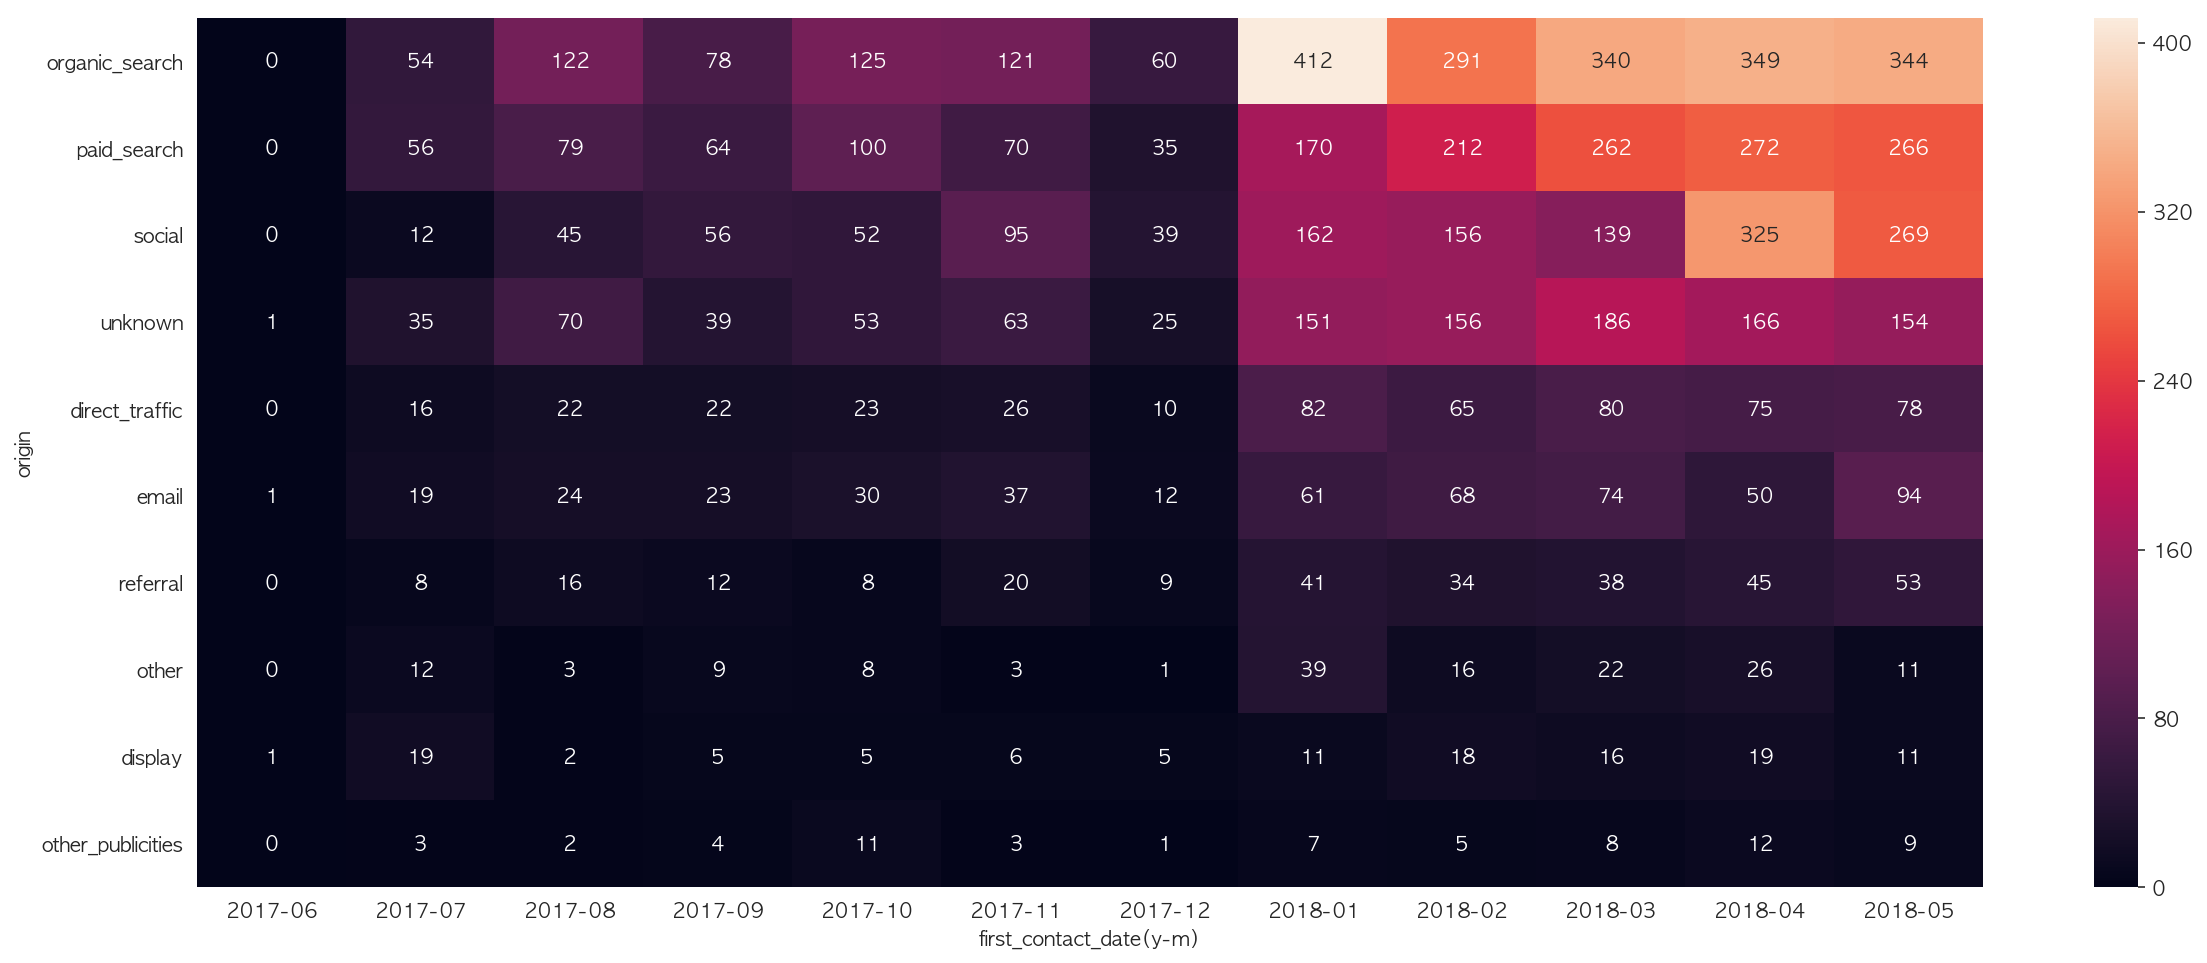

In [7]:
# Plot the monthly volume by channel
plt.figure(figsize=(20,8))
sns.heatmap(mql_origin, annot=True, fmt='g')

* The majority of MQLs come from organic_search channel.
* Paid search is the second biggest contributor to lead generation after 'organic search'.
* The third one is 'social' which acquired MQLs more than or similar to 'paid search' since April 2018.
* If the marginal cost of paid search increases, it would be possible to examine effectiveness of 'social' as an alternative.

## 2. Sales Performance Overview

After a MQL filled a form on landing page to sign up for seller, a `Sales Development Representative(SDR)` contacted the MQL and gathered more information about the lead. Then a `Sales Representative(SR)` consulted the MQL to be seller. **So interaction between SDRs/SRs and MQLs can affect conversion from MQLs to sellers.**
At this section I will deal with two aspects of *sales result*, *conversion rate* and *sales length*.
* *A MQL who finally signed up for seller is called a `closed deal`.*

In [8]:
# Load 'closed deals' dataset
cd = pd.read_csv('data/olist_closed_deals_dataset.csv',
                 parse_dates=['won_date'])

print(cd.shape)
cd.head(5)

(842, 14)


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0


In [9]:
# Merge 'MQL' with 'closed deals'
mql_cd = pd.merge(mql,
                  cd,
                  how='left',
                  on='mql_id')

print(mql_cd.shape)
mql_cd.head(3)

(8000, 18)


,mql_id,first_contact_date,landing_page_id,origin,first_contact_date(y-m),seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,2018-02,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,2017-10,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,2018-03,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
mql_cd['seller_id(bool)'] = mql_cd['seller_id'].notnull()
print(mql_cd.shape)
mql_cd[['seller_id', 'seller_id(bool)']].head()

(8000, 19)


,seller_id,seller_id(bool)
0,NaN,False
1,NaN,False
2,NaN,False
3,NaN,False
4,2c43fb513632d29b3b58df74816f1b06,True


### Monthly Closed Deals

In [11]:
# Compute monthly closed deals
monthly_cd = mql_cd.groupby('first_contact_date(y-m)')['seller_id(bool)'].sum()
monthly_cd.to_frame().T

first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
seller_id(bool),0.0,2.0,9.0,7.0,14.0,18.0,11.0,152.0,149.0,167.0,183.0,130.0


Text(0.5, 1.0, 'Closed Deal Volume (Jun 2017 - May 2018)')

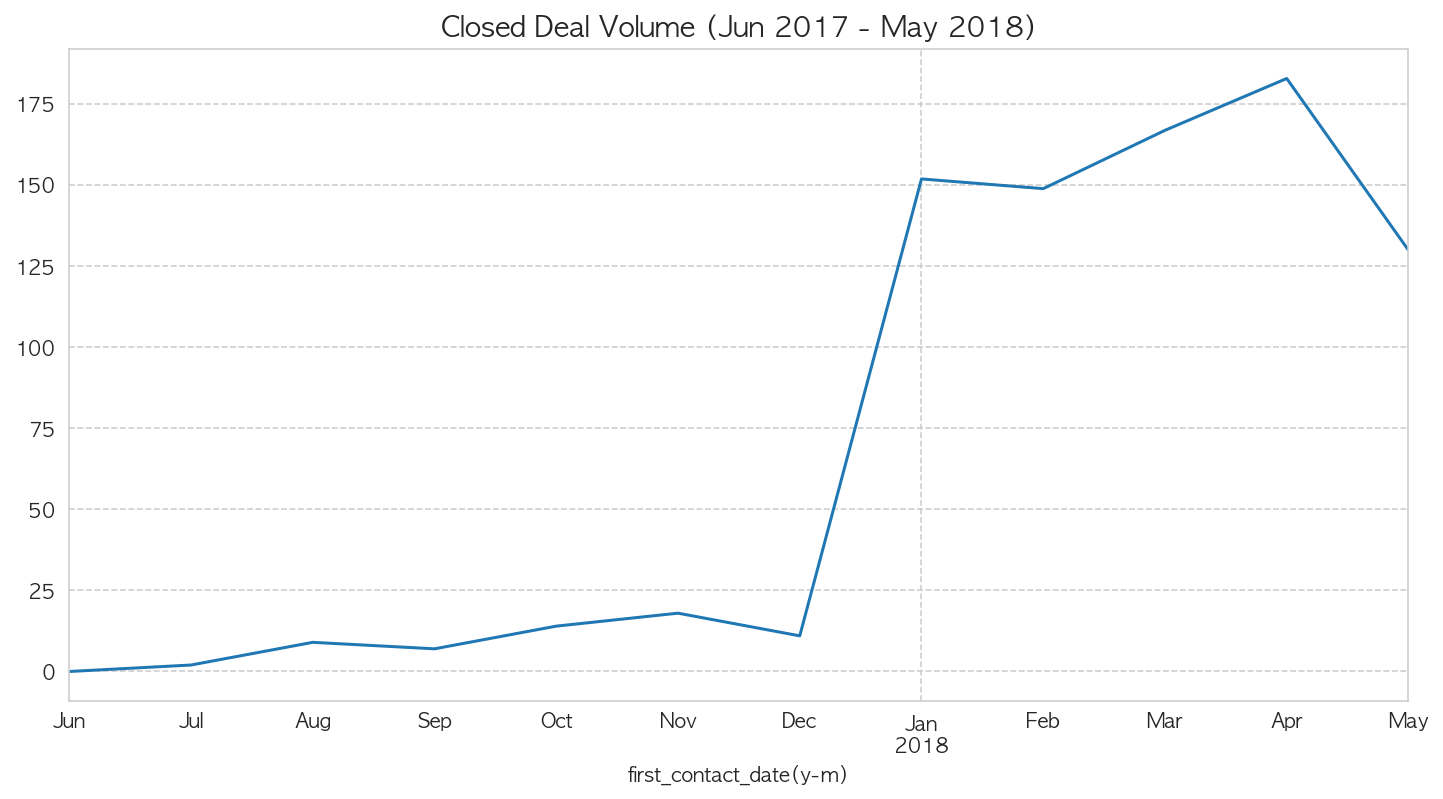

In [12]:
# Plot the monthly volume of closed deals
monthly_cd.plot.line(figsize=(12, 6))
plt.title('Closed Deal Volume (Jun 2017 - May 2018)', fontsize=14)

Likewise, monthly volume of closed deals sharply increased after 2018.

### Conversion Rate

`Conversion rate` means the percentage of MQLs who finally signed up for sellers (closed deals).
   
`Conversion rate` = # of closed deals / # of MQLs

In [13]:
monthly_conversion = mql_cd.groupby('first_contact_date(y-m)')['seller_id(bool)'].agg(['count','sum'])

monthly_conversion['conversion_rate(%)'] = ((monthly_conversion['sum'] / monthly_conversion['count']) * 100).round(1)

monthly_conversion.T


first_contact_date(y-m),2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
count,4.0,239.0,386.0,312.0,416.0,445.0,200.0,1141.0,1028.0,1174.0,1352.0,1303.0
sum,0.0,2.0,9.0,7.0,14.0,18.0,11.0,152.0,149.0,167.0,183.0,130.0
conversion_rate(%),0.0,0.8,2.3,2.2,3.4,4.0,5.5,13.3,14.5,14.2,13.5,10.0


Text(0, 0.5, 'Conversion Rate(%)')

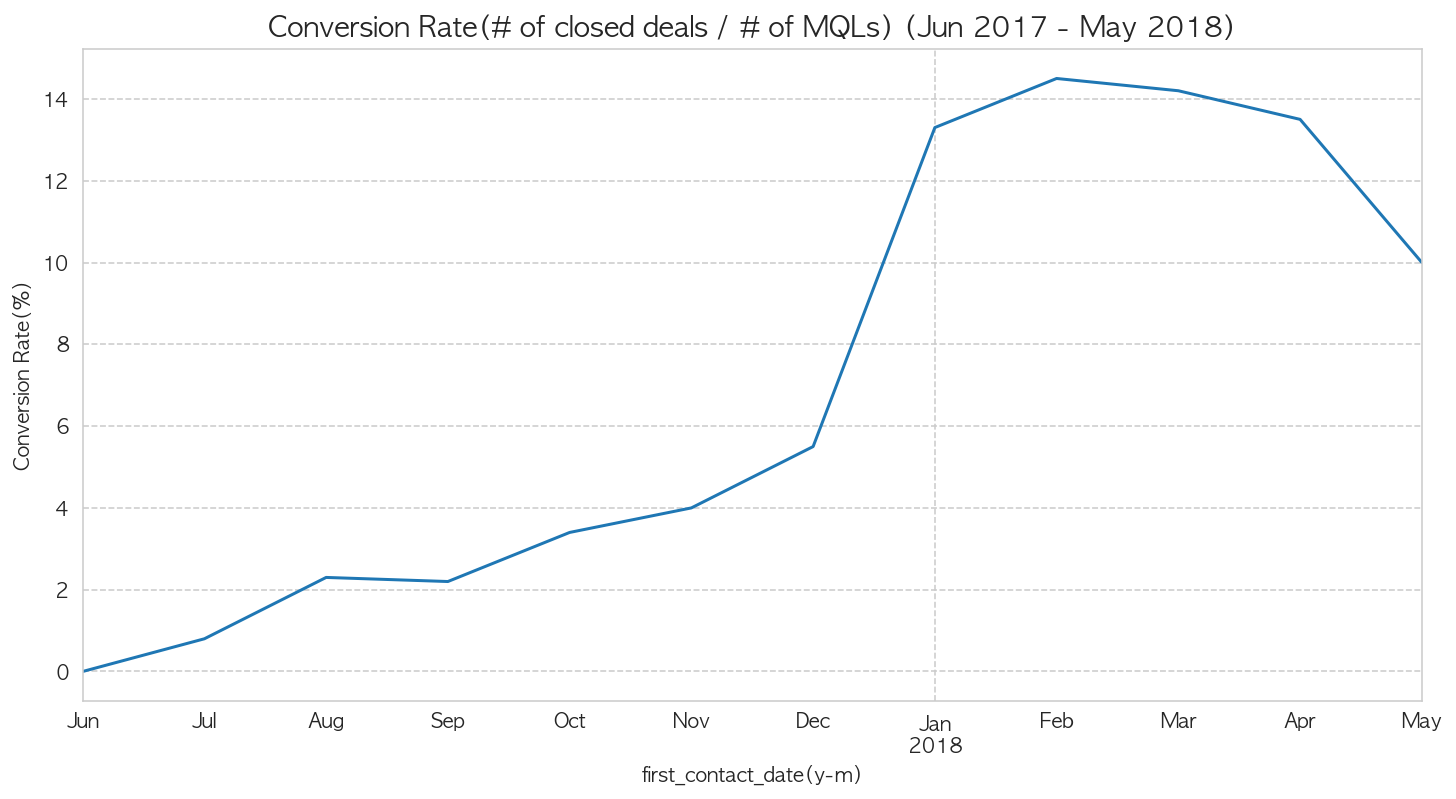

In [14]:
# Plot the monthly conversion rate
monthly_conversion['conversion_rate(%)'].plot.line(figsize=(12, 6))
plt.title('Conversion Rate(# of closed deals / # of MQLs) (Jun 2017 - May 2018)', fontsize=14)
plt.ylabel('Conversion Rate(%)')

Conversion rate also increased with volume.

### Sales Length

`Sales length` means period from first contact to signing up for seller.

In [15]:
# Calculate sales length in days
mql_cd['sales_length(day)'] = np.ceil((mql_cd['won_date'] - mql_cd['first_contact_date'])\
       .dt.total_seconds() / (60*60*24))

print(mql_cd.shape)
mql_cd.loc[mql_cd['sales_length(day)'].notnull(),['first_contact_date', 'won_date', 'sales_length(day)']].head(7)



(8000, 20)


,first_contact_date,won_date,sales_length(day)
4,2018-02-21,2018-02-26 19:58:54,6.0
12,2018-04-04,2018-05-08 20:17:59,35.0
14,2018-04-03,2018-06-05 17:27:23,64.0
39,2018-01-14,2018-01-17 13:51:03,4.0
67,2017-10-09,2018-07-03 20:17:45,268.0
79,2018-02-06,2018-02-07 18:04:05,2.0
82,2018-02-20,2018-04-16 18:18:22,56.0


In [16]:
# Separate sales length for each year
closed_deal = (mql_cd['seller_id'].notnull())
lead_2017 = mql_cd['first_contact_date'].dt.year == 2017
lead_2018 = mql_cd['first_contact_date'].dt.year == 2018

sales_length_2017 = mql_cd.loc[closed_deal & lead_2017,'sales_length(day)']
sales_length_2018 = mql_cd.loc[closed_deal & lead_2018,'sales_length(day)']


(0, 500)

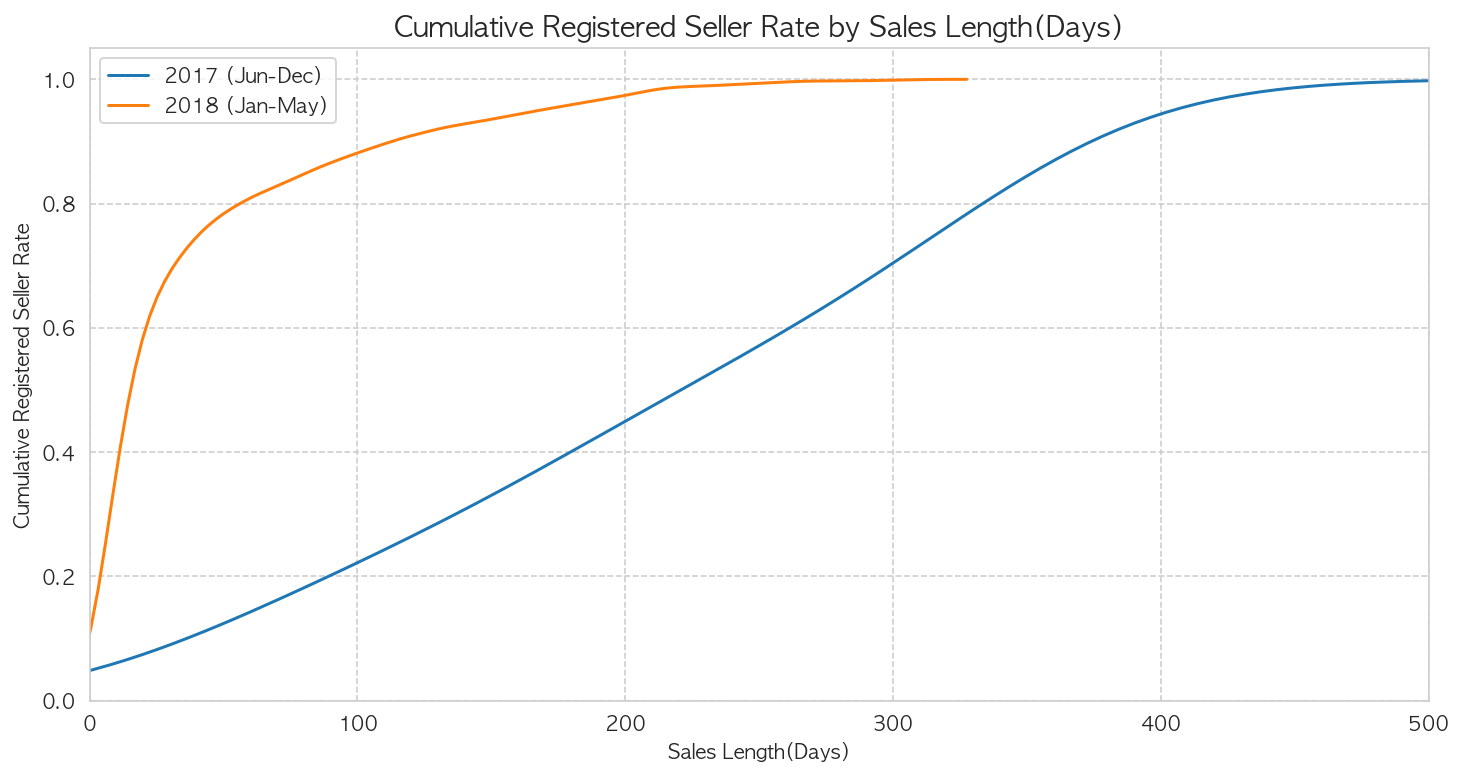

In [17]:
# Plot the sales length of each year
fig, ax = plt.subplots(figsize=(12,6))

sns.kdeplot(sales_length_2017, 
           cumulative=True,
           label='2017 (Jun-Dec)',
           ax=ax)
sns.kdeplot(sales_length_2018,
           cumulative=True,
           label='2018 (Jan-May)')
ax.set_title('Cumulative Registered Seller Rate by Sales Length(Days)', fontsize=14)

plt.xlabel('Sales Length(Days)')
plt.ylabel('Cumulative Registered Seller Rate')

plt.xlim(0,500)

Sales length was dramatically shortened in 2018. While 13.1% of deals were closed within 50 days in 2017, 78.9% was closed in 2018. **In a nutshell, both conversion rate and sales length were improved in 2018 against 2017.**

### Digging into Closed Deal

I will explore closed deals in more depth to see whether there is room for improvement in sales process. Specifically I'm looking into three dimensions of closed deals(`lead type`, `business segment`, `business type`) with `lead behaviour profile` as an axis.

 Characteristics of Closed Deal

In [18]:
cd_profile = cd[cd['lead_behaviour_profile'].notnull()].copy()

print(cd_profile.shape)
cd_profile['lead_behaviour_profile'].value_counts()

(665, 14)


cat            407
eagle          123
wolf            95
shark           24
cat, wolf        8
eagle, cat       3
eagle, wolf      3
shark, cat       1
shark, wolf      1
Name: lead_behaviour_profile, dtype: int64

In [19]:
# Combine four types of mixed profiles(2.4%) into 'others'
profile_list = ['cat', 'eagle', 'wolf', 'shark']

cd_profile['lead_behaviour_profile(upd)'] = cd_profile.lead_behaviour_profile \
                                                      .map(lambda profile: profile
                                                           if profile in profile_list
                                                           else 'others')

print(cd_profile.shape)
cd_profile['lead_behaviour_profile(upd)'].value_counts()

(665, 15)


cat       407
eagle     123
wolf       95
shark      24
others     16
Name: lead_behaviour_profile(upd), dtype: int64

In [20]:
# Create 'profile - lead type' table
cols = cd_profile['lead_type'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_leadType = pd.pivot_table(cd_profile,
                                  index='lead_behaviour_profile(upd)',
                                  columns='lead_type',
                                  values='seller_id',
                                  aggfunc='count',
                                  fill_value=0)

profile_leadType = profile_leadType.reindex(index)[cols]
profile_leadType

lead_type,online_medium,online_big,industry,offline,online_small,online_beginner,online_top,other
cat,157,72,49,49,37,31,8,2
eagle,46,11,25,22,12,6,1,0
wolf,45,16,14,9,6,5,0,0
shark,9,4,4,5,1,0,1,0
others,8,3,2,1,1,0,0,1


In [21]:
# Create 'profile - business type' table
cols = cd_profile['business_type'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_businessType = pd.pivot_table(cd_profile, 
                                     index='lead_behaviour_profile(upd)',
                                     columns='business_type',
                                     values='seller_id',
                                     aggfunc='count',
                                     fill_value=0)

profile_businessType = profile_businessType.reindex(index)[cols]
profile_businessType


business_type,reseller,manufacturer,other
cat,284,116,2
eagle,83,37,0
wolf,69,26,0
shark,16,7,0
others,13,2,1


In [22]:
# Create 'profile - business segment' table
cols = cd_profile['business_segment'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_segment = pd.pivot_table(cd_profile,
                                 index='lead_behaviour_profile(upd)',
                                 columns='business_segment',
                                 values='seller_id',
                                 aggfunc='count',
                                 fill_value=0)

profile_segment = profile_segment.reindex(index)[cols]
profile_segment

business_segment,home_decor,health_beauty,car_accessories,construction_tools_house_garden,household_utilities,audio_video_electronics,computers,pet,sports_leisure,food_supplement,...,music_instruments,home_appliances,gifts,jewerly,other,party,air_conditioning,perfume,games_consoles,religious
cat,51,43,41,35,32,38,16,15,17,13,...,2,3,3,3,2,2,0,1,1,1
eagle,11,13,12,11,12,8,3,4,4,5,...,2,1,1,0,0,1,0,1,0,0
wolf,14,8,9,7,9,8,5,4,1,2,...,2,2,0,1,0,0,1,0,0,0
shark,4,5,2,4,3,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
others,0,1,2,0,1,0,2,0,0,0,...,0,0,0,0,1,0,0,0,1,0


Text(0.5, 1.0, 'Behaviour Profile(y) - Business Segement(x)')

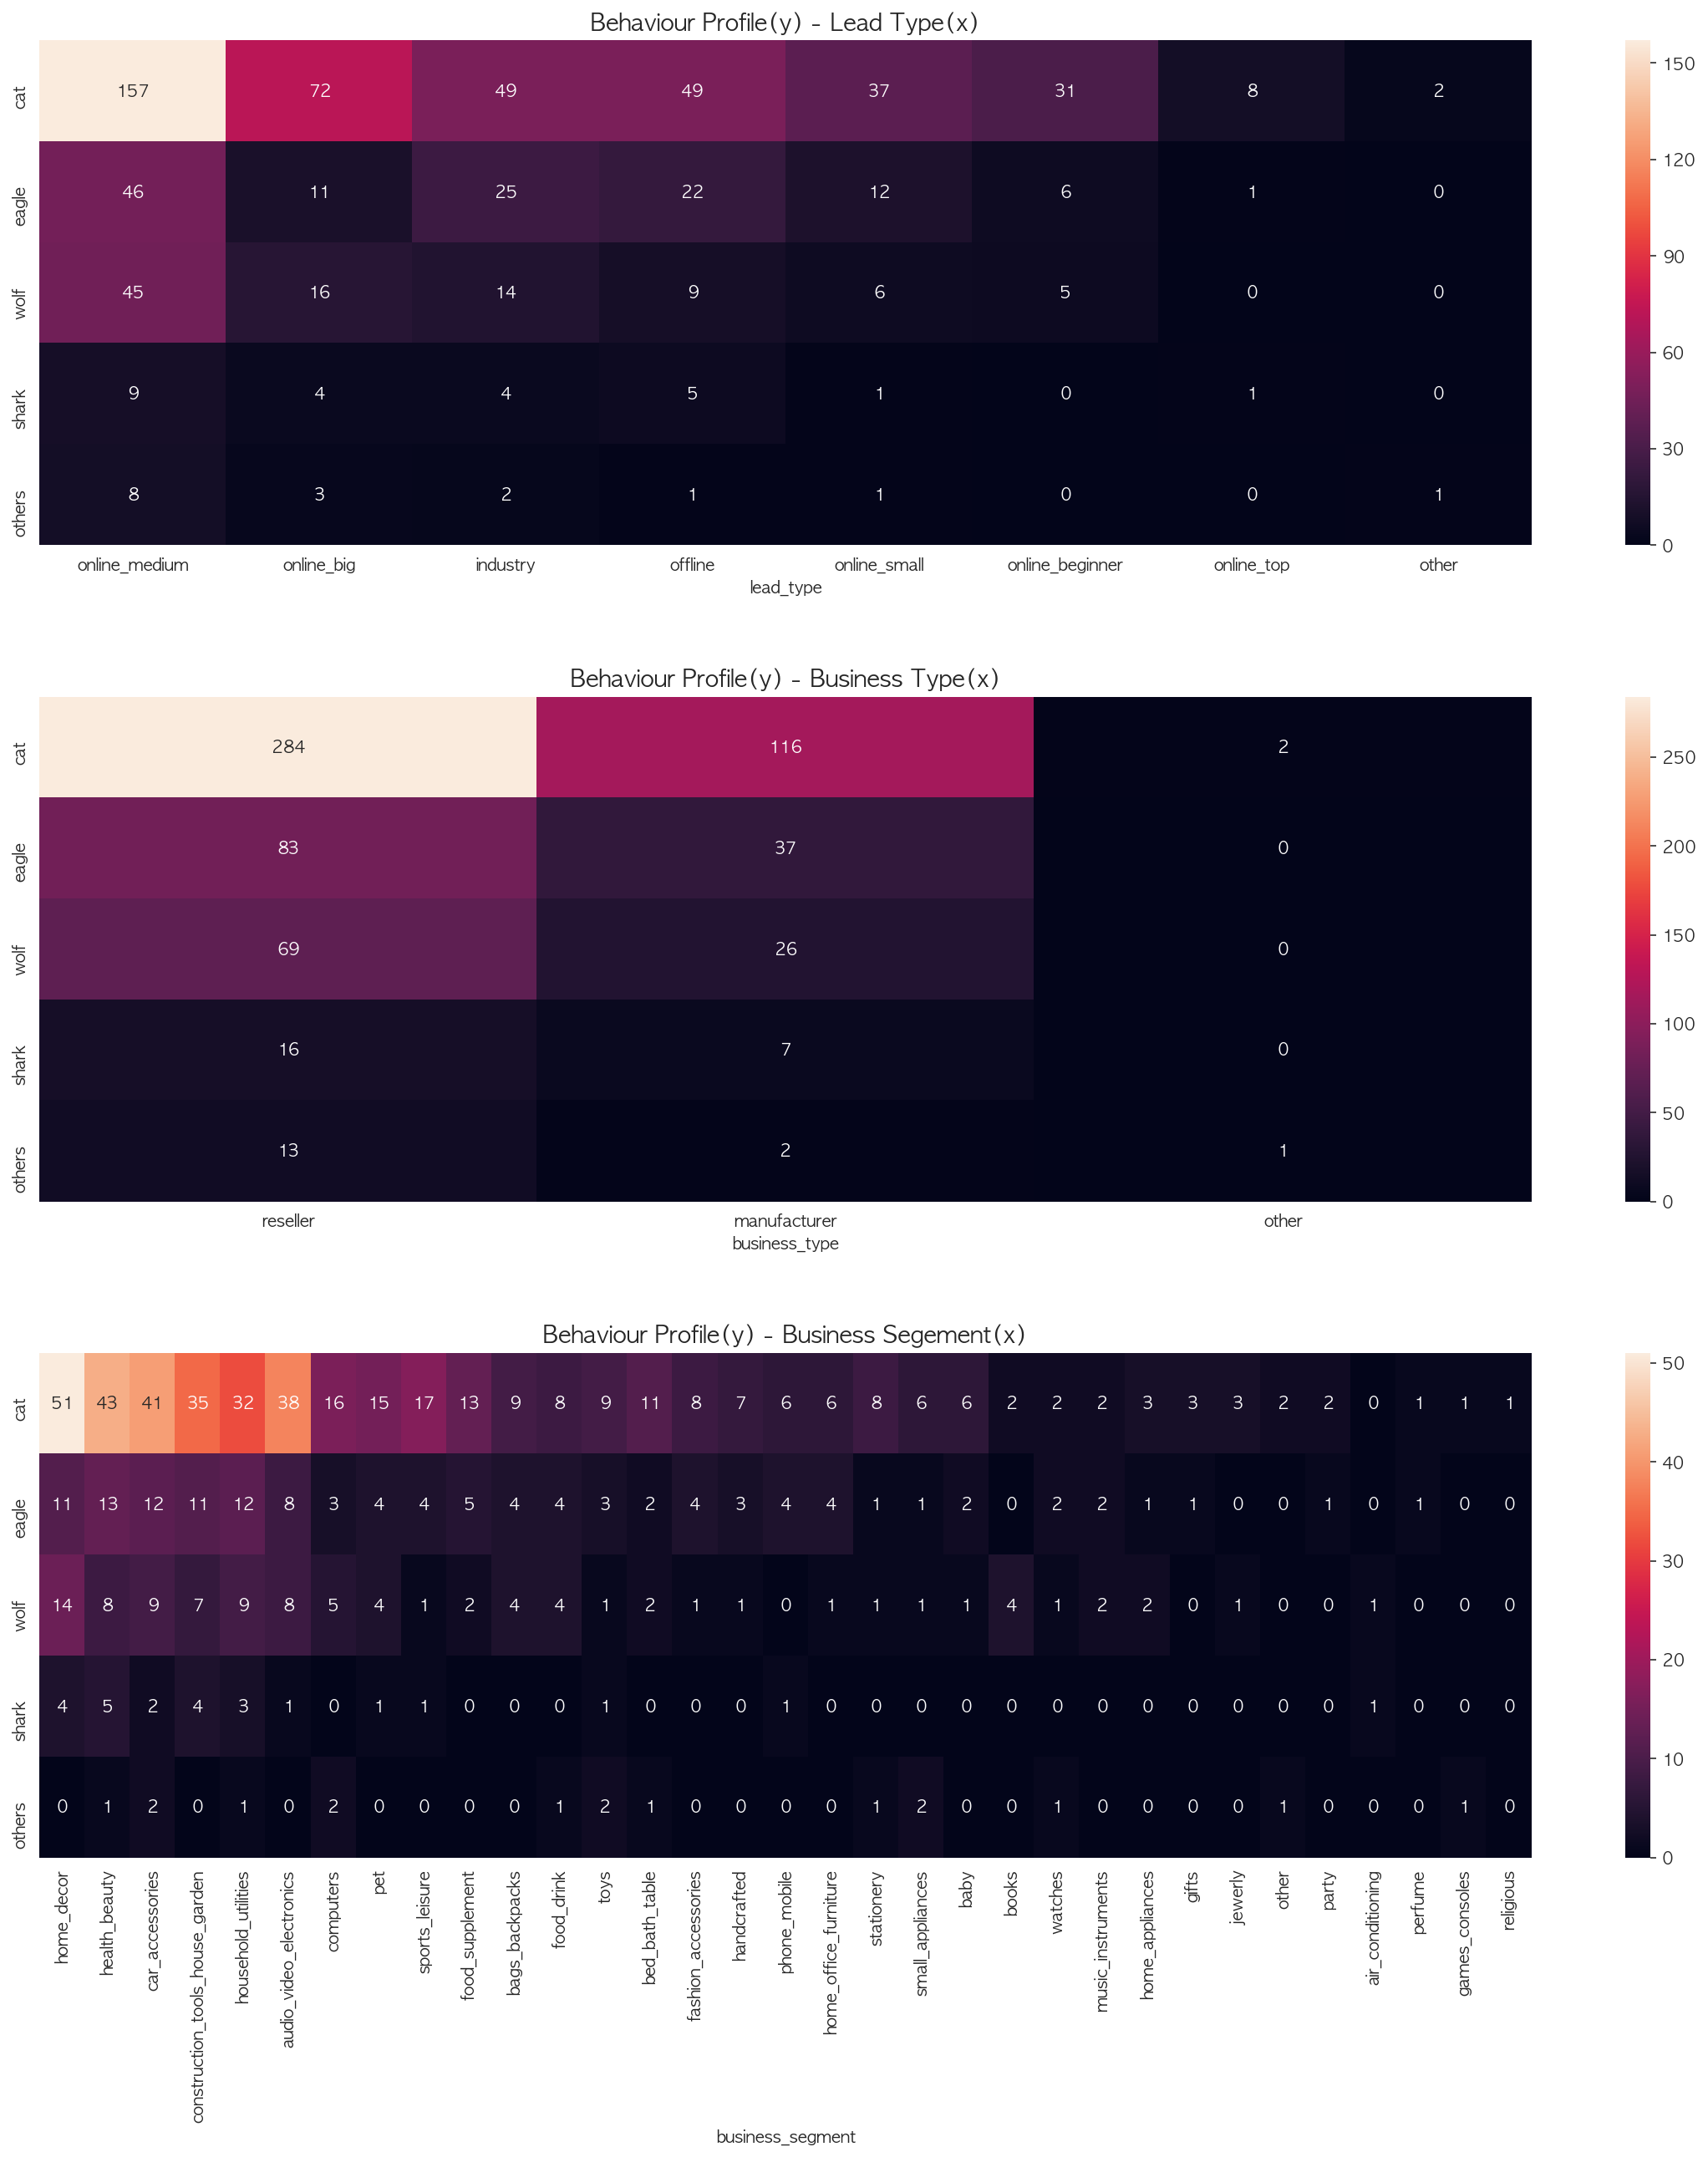

In [23]:
# Plot the above three tables

figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,20))
figure.subplots_adjust(hspace=0.3)

sns.heatmap(profile_leadType,
           annot=True,
           fmt='g',
           ax=ax1)
sns.heatmap(profile_businessType,
           annot=True,
           fmt='g',
           ax=ax2)
sns.heatmap(profile_segment,
           annot=True,
           fmt='g',
           ax=ax3)

ax1.set_title('Behaviour Profile(y) - Lead Type(x)', fontsize=14)
ax2.set_title('Behaviour Profile(y) - Business Type(x)', fontsize=14)
ax3.set_title('Behaviour Profile(y) - Business Segement(x)', fontsize=14)

'lead_behaviour_profile' is related to DISC personality test. Each type has the meaning as follows.  
_\* Source: [DISC Profile](https://www.discprofile.com/what-is-disc/overview/)_

Behaviour_profile | DISC_profile | Description
------------------- | ------------- | ------------
Cat | Steadiness | Person places emphasis on cooperation, sincerity, dependability
Eagle | Influence | Person places emphasis on influencing or persuading others, openness, relationships
Wolf | Conscientiousness | Person places emphasis on quality and accuracy, expertise, competency
Shark | Dominance | Person places emphasis on accomplishing results, the bottom line, confidence
 
+ Closed deals are won in order of cat, eagle, wolf and shark based on descending volume in all three dimensions.
+ In consideration of business context, it might make sense that conversion rate of wolf (accuracy-focused) or shark (result-focused) was lower than cat (cooperation-focused) or eagle (relationship-focused).

If so, sales performance could be improved by matching SDRs/SRs with MQLs properly.

#### SDR/SR Performance by Behaviour Profile

In [24]:
# Create 'profile-SDR' table
cols = cd_profile['sdr_id'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_sdr = pd.pivot_table(cd_profile,
                             index='lead_behaviour_profile(upd)',
                             columns='sdr_id',
                             values='seller_id',
                             aggfunc='count',
                             fill_value=0)

profile_sdr = profile_sdr.reindex(index)[cols]
profile_sdr

sdr_id,4b339f9567d060bcea4f5136b9f5949e,9d12ef1a7eca3ec58c545c678af7869c,a8387c01a09e99ce014107505b92388c,9e4d1098a3b0f5da39b0bc48f9876645,068066e24f0c643eb1d089c7dd20cd73,370c9f455f93a9a96cbe9bea48e70033,09285259593c61296eef10c734121d5b,f42a2bd194f7802ab052a815c8de65b7,34d40cdaf94010a1d05b0d6212f9e909,56bf83c4bb35763a51c2baab501b4c67,...,2b63542749aa9caf15f21816da1db341,b34f6eba10f46bf9a657a01c108a8284,6aa3b86a83d784b05f0e37e26b20860d,0cdad77786224a7cefea567b8c75c3c1,084b6fbb10729ed4da8c3d3f5a3ae7c9,5b7ce8c2b0fe4c2f52a0763046914ef4,19f3cd308f1455b3fa09a282e0d496f4,e4a6222cdb5b34375400904f03d8e6a5,b1b3ec93fc27a19fdb1c1b1fc997776a,282f16e20d50cb18d05182e80f6b9dd6
cat,52,35,50,37,43,26,25,23,30,24,...,2,1,1,2,1,1,1,0,0,0
eagle,9,22,4,10,3,14,8,7,8,16,...,0,0,0,0,0,0,0,0,0,0
wolf,42,6,3,3,3,7,7,7,1,0,...,1,0,0,0,0,0,0,0,0,1
shark,8,0,0,3,2,2,2,1,2,0,...,0,1,1,0,0,0,0,0,0,0
others,1,1,0,0,0,1,0,4,0,0,...,0,0,0,0,0,0,0,1,1,0


In [25]:
# Create 'profile-SR' table
cols = cd_profile['sr_id'].value_counts().index
index = cd_profile['lead_behaviour_profile(upd)'].value_counts().index

profile_sr = pd.pivot_table(cd_profile,
                            index='lead_behaviour_profile(upd)',
                            columns='sr_id',
                            values='seller_id',
                            aggfunc='count',
                            fill_value=0)

profile_sr = profile_sr.reindex(index)[cols] 
profile_sr

sr_id,4ef15afb4b2723d8f3d81e51ec7afefe,85fc447d336637ba1df43e793199fbc8,6565aa9ce3178a5caf6171827af3a9ba,d3d1e91a157ea7f90548eef82f1955e3,de63de0d10a6012430098db33c679b0b,2695de1affa7750089c0455f8ce27021,495d4e95a8cf8bbf8b432b612a2aa328,fbf4aef3f6915dc0c3c97d6812522f6a,068066e24f0c643eb1d089c7dd20cd73,c638112b43f1d1b86dcabb0da720c901,...,9e4d1098a3b0f5da39b0bc48f9876645,56bf83c4bb35763a51c2baab501b4c67,9ae085775a198122c5586fa830ff7f2b,34d40cdaf94010a1d05b0d6212f9e909,4b339f9567d060bcea4f5136b9f5949e,9749123c950bf8363ace42cb1c2d0815,9d12ef1a7eca3ec58c545c678af7869c,0a0fb2b07d841f84fb6714e35c723075,6aa3b86a83d784b05f0e37e26b20860d,b90f87164b5f8c2cfa5c8572834dbe3f
cat,58,41,31,28,37,34,30,30,11,17,...,16,17,12,3,7,2,3,1,0,0
eagle,23,7,13,12,7,9,6,9,7,5,...,6,2,4,4,0,0,0,0,0,1
wolf,12,11,11,11,5,6,7,2,4,3,...,0,2,5,0,2,4,1,0,0,0
shark,0,4,0,2,4,2,2,2,1,0,...,2,2,1,0,0,1,0,0,0,0
others,2,0,0,1,0,2,1,0,2,0,...,0,0,1,3,0,0,2,0,1,0


1. SDR
 + 1st and 3rd SDRs are eminent in handling cat.
 + 2nd and 10th SDRs are specialized in eagle.
 + 1st SDR is also unparalleled in dealing with wolf.
 + As to shark 1st SDR is better than the others, but not enough to claim to be an expert.
 + __SDR is the first contact point of MQL so they do not know the lead's behaviour profile yet. Therefore sharing top performers' expertise in cat, eagle or wolf can enhance team performance.__
 + __In regard to shark, external resources may be helpful in building capability.__

2. SR
  + 1st SR has matchless skills in managing both cat and eagle.
  + SRs on the first four places are good at handling wolf, but not as much as their highest performing fields.
  + 2nd and 5th are the best performers in regard to shark, but hard to say 'proficient'.
  + __Eagle can be assigned to 2nd SR. Further, spreading knowledge among the team can improve team performance.__
  + __Like SDR, external knowledge sources can be a way to boost performance.__

## 3. Closed Deal Performance Overview
In this part I will see the total revenue from closed deals after signing in and drill down the top revenue-generating segment.

In [26]:
# Load datasets
cd = pd.read_csv('data/olist_closed_deals_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
orders = pd.read_csv('data/olist_orders_dataset.csv',
                     parse_dates=['order_purchase_timestamp'])
products = pd.read_csv('data/olist_products_dataset.csv')
product_translation = pd.read_csv('data/product_category_name_translation.csv')

In [27]:
print(cd.shape)
print(order_items.shape)
print(orders.shape)
print(products.shape)
print(product_translation.shape)

(842, 14)
(112650, 7)
(99441, 8)
(32951, 9)
(71, 2)


In [28]:
# Merge all of the data
data = pd.merge(cd,order_items,
                how='inner', on='seller_id')
data = pd.merge(data, orders,
                how='inner', on='order_id')
data = pd.merge(data, products,
                how='inner', on='product_id')
data = pd.merge(data, product_translation,
                how='left', on='product_category_name')
data.shape

(5044, 36)

In [29]:
data = data[data['order_status'] == 'delivered']
data['order_purchase_timestamp(y-m)'] = data['order_purchase_timestamp'].dt.to_period('M')

print(data.shape)
data.head(3)

(4984, 37)


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_purchase_timestamp(y-m)
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,...,pet_shop,56.0,1538.0,2.0,625.0,23.0,17.0,19.0,pet_shop,2018-06
1,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,...,ferramentas_jardim,25.0,432.0,1.0,2825.0,29.0,29.0,29.0,garden_tools,2018-07
2,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,...,pet_shop,53.0,1494.0,2.0,900.0,26.0,19.0,23.0,pet_shop,2018-06


### Monthly Revenues by Business Segment

In [30]:
data.groupby(by='business_segment')['price'].sum().sort_values(ascending=False)

business_segment
watches                            115901.08
health_beauty                       88924.34
household_utilities                 51280.87
audio_video_electronics             49423.44
small_appliances                    47674.87
home_decor                          43809.33
pet                                 40498.83
construction_tools_house_garden     32007.07
car_accessories                     30005.98
home_appliances                     26241.17
sports_leisure                      15591.52
bed_bath_table                      15448.53
baby                                14210.96
bags_backpacks                      13933.81
computers                           11772.29
food_supplement                     10364.05
home_office_furniture                9900.56
stationery                           8131.36
fashion_accessories                  7831.08
books                                6942.89
music_instruments                    5839.64
toys                                 5

In [31]:
cols = data.groupby(by='business_segment') \
           .price \
           .sum() \
           .sort_values(ascending=False) \
           .index
monthly_segment_revenue = data.pivot_table(index='order_purchase_timestamp(y-m)',
                                            columns='business_segment',
                                            values='price',
                                            aggfunc='sum',
                                            fill_value=0)

monthly_segment_revenue = monthly_segment_revenue[cols]
monthly_segment_revenue



business_segment,watches,health_beauty,household_utilities,audio_video_electronics,small_appliances,home_decor,pet,construction_tools_house_garden,car_accessories,home_appliances,...,books,music_instruments,toys,phone_mobile,food_drink,air_conditioning,gifts,handcrafted,games_consoles,party
order_purchase_timestamp(y-m),,,,,,,,,,,,,,,,,,,,,
2018-01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0,0.00,0.0,0,0.00
2018-02,5935.46,28.00,443.60,20.00,140.00,1042.50,211.96,677.56,178.90,0.00,...,0.00,1447.90,234.69,0.00,0.00,0,0.00,0.0,0,0.00
2018-03,27439.45,567.50,2233.49,2842.87,12620.00,531.50,377.86,1154.44,347.00,145.97,...,19.90,179.90,238.10,642.00,14.90,0,0.00,0.0,0,0.00
2018-04,21918.00,6793.63,5008.94,3074.49,12529.90,2857.34,4586.34,2611.66,4266.00,869.98,...,344.45,439.79,923.06,1189.90,223.50,0,189.00,0.0,0,0.00
2018-05,31286.81,17073.44,10153.85,9813.11,14447.50,6134.17,3316.38,6499.96,3451.86,435.00,...,3023.27,494.86,670.41,152.90,413.80,0,0.00,0.0,0,0.00
2018-06,11547.88,25298.46,10497.65,10067.49,3909.80,8414.03,6292.87,4591.75,5414.06,2494.49,...,1020.19,973.59,1116.54,1247.59,302.40,282,0.00,93.8,0,0.00
2018-07,7393.44,20035.20,11568.15,12017.70,1187.20,10980.97,9526.63,8485.62,6637.60,16278.83,...,1554.74,1189.70,1153.53,449.70,1148.49,278,482.98,93.8,438,0.00
2018-08,10380.04,19128.11,11375.19,11587.78,2840.47,13848.82,16186.79,7986.08,9710.56,6016.90,...,980.34,1113.90,1220.53,599.30,1599.84,2090,339.29,688.3,219,388.98


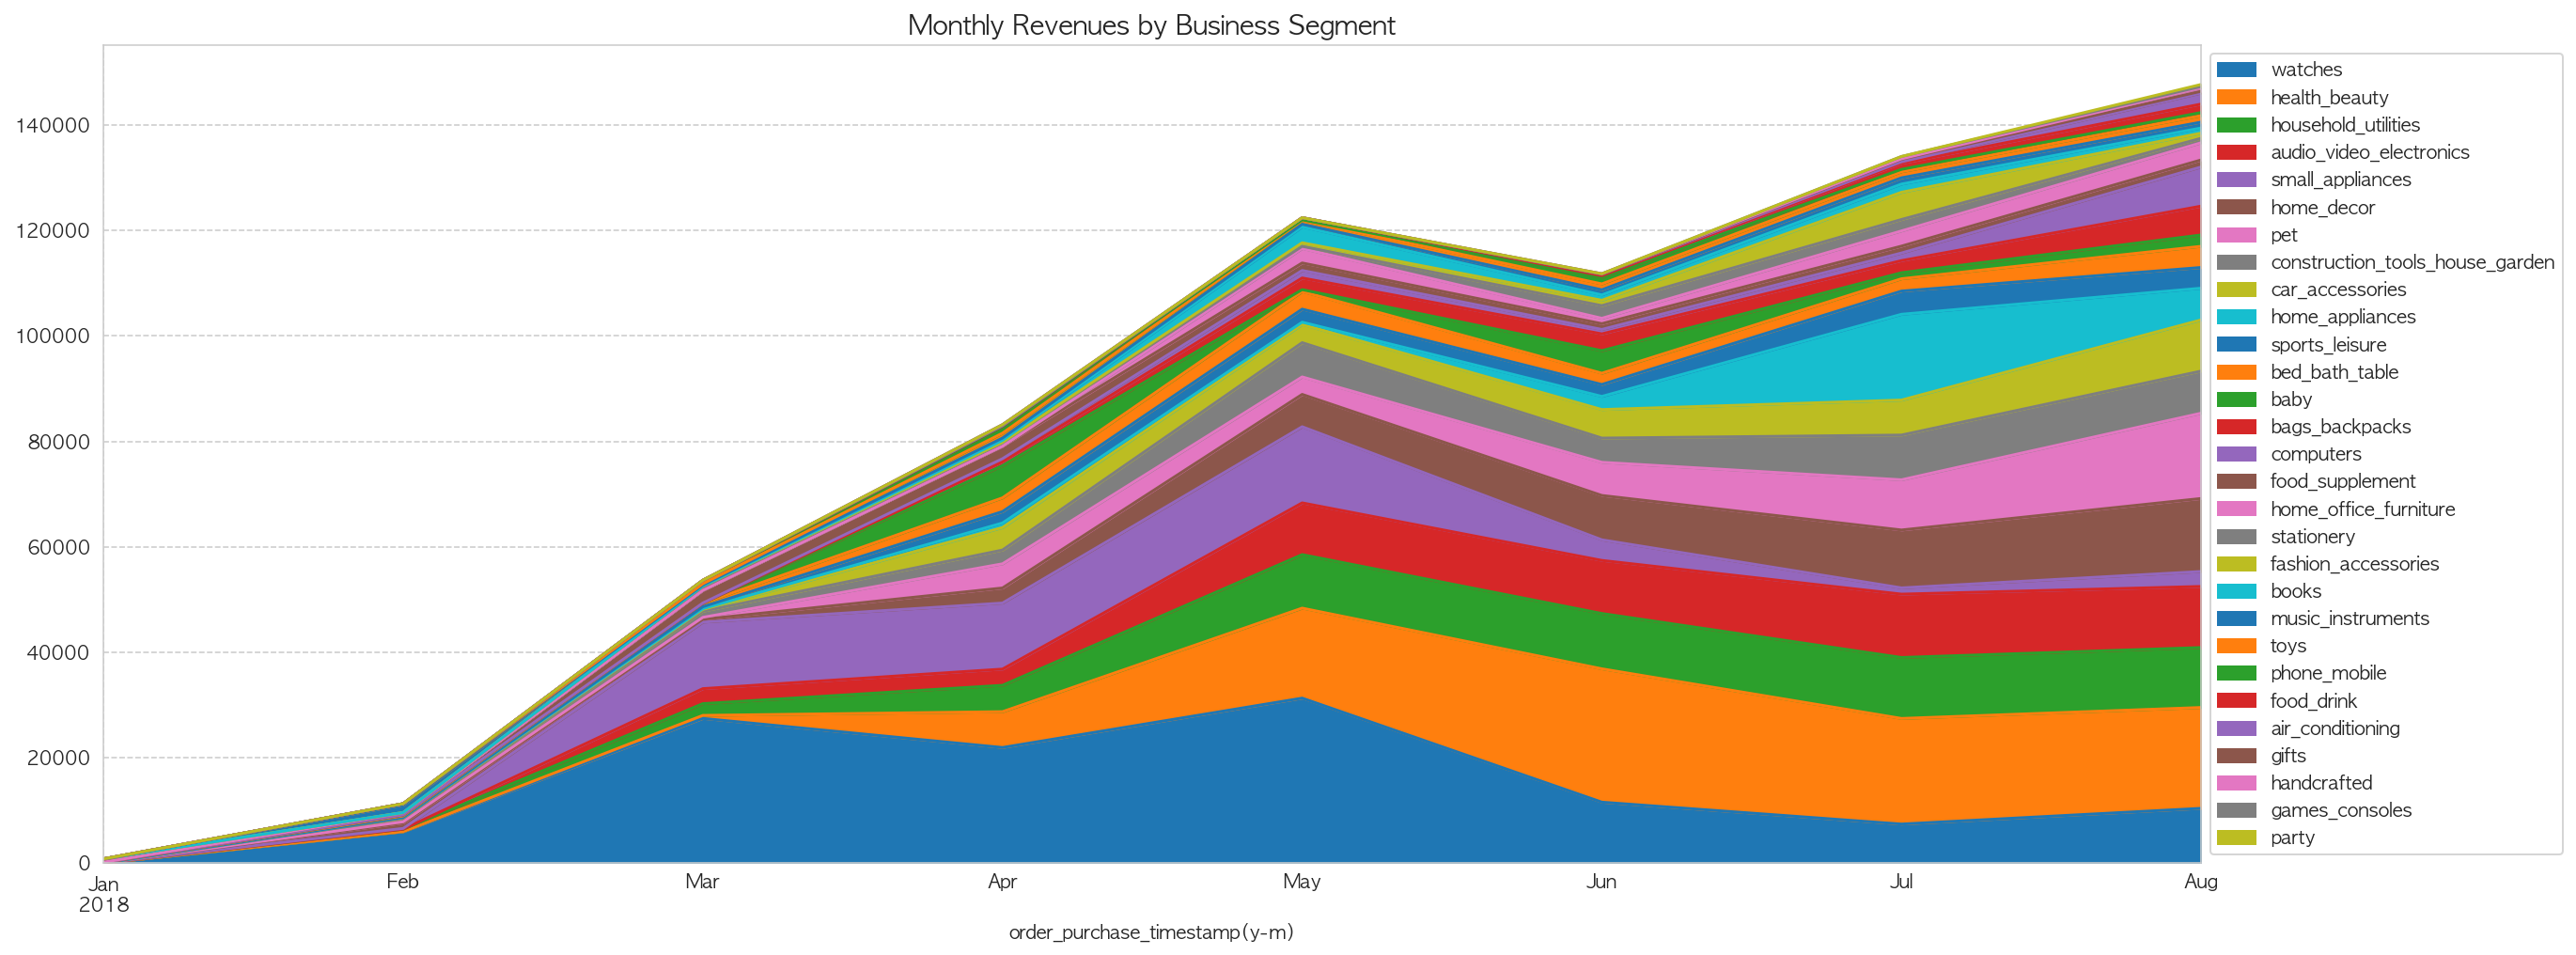

In [32]:
# Plot the monthly revenues by segment
monthly_segment_revenue.plot.area(figsize=(20,8))

plt.title('Monthly Revenues by Business Segment', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

The biggest segment was 'watches', which generated 17.4% of total revenues.

#### Watches Revenue by Product Category

In [33]:
# Create watches segment dataframe
watches = data[data.business_segment == 'watches']
watches.shape

(586, 37)

In [34]:
# Create monthly revenues by product category
cols = watches.groupby('product_category_name_english') \
              .price \
              .sum() \
              .sort_values(ascending=False) \
              .index

monthly_revenue_category =  watches.pivot_table(index='order_purchase_timestamp(y-m)',
                   columns='product_category_name_english',
                   values='price',
                   aggfunc='sum',
                   fill_value=0)

monthly_revenue_category = monthly_revenue_category[cols]
monthly_revenue_category

product_category_name_english,watches_gifts,audio,electronics,sports_leisure,cool_stuff,market_place,perfumery
order_purchase_timestamp(y-m),,,,,,,
2018-02,5065.36,590.00,280.10,0,0,0.0,0
2018-03,19106.69,7547.76,240.00,545,0,0.0,0
2018-04,15588.14,5609.89,719.97,0,0,0.0,0
2018-05,29070.81,2216.00,0.00,0,0,0.0,0
2018-06,9727.88,1172.00,0.00,468,180,0.0,0
2018-07,5747.44,876.00,370.00,0,180,0.0,220
2018-08,8077.86,550.00,1464.58,0,0,287.6,0


Text(0.5, 1.0, 'Monthly Revenues by Product Category of Watches')

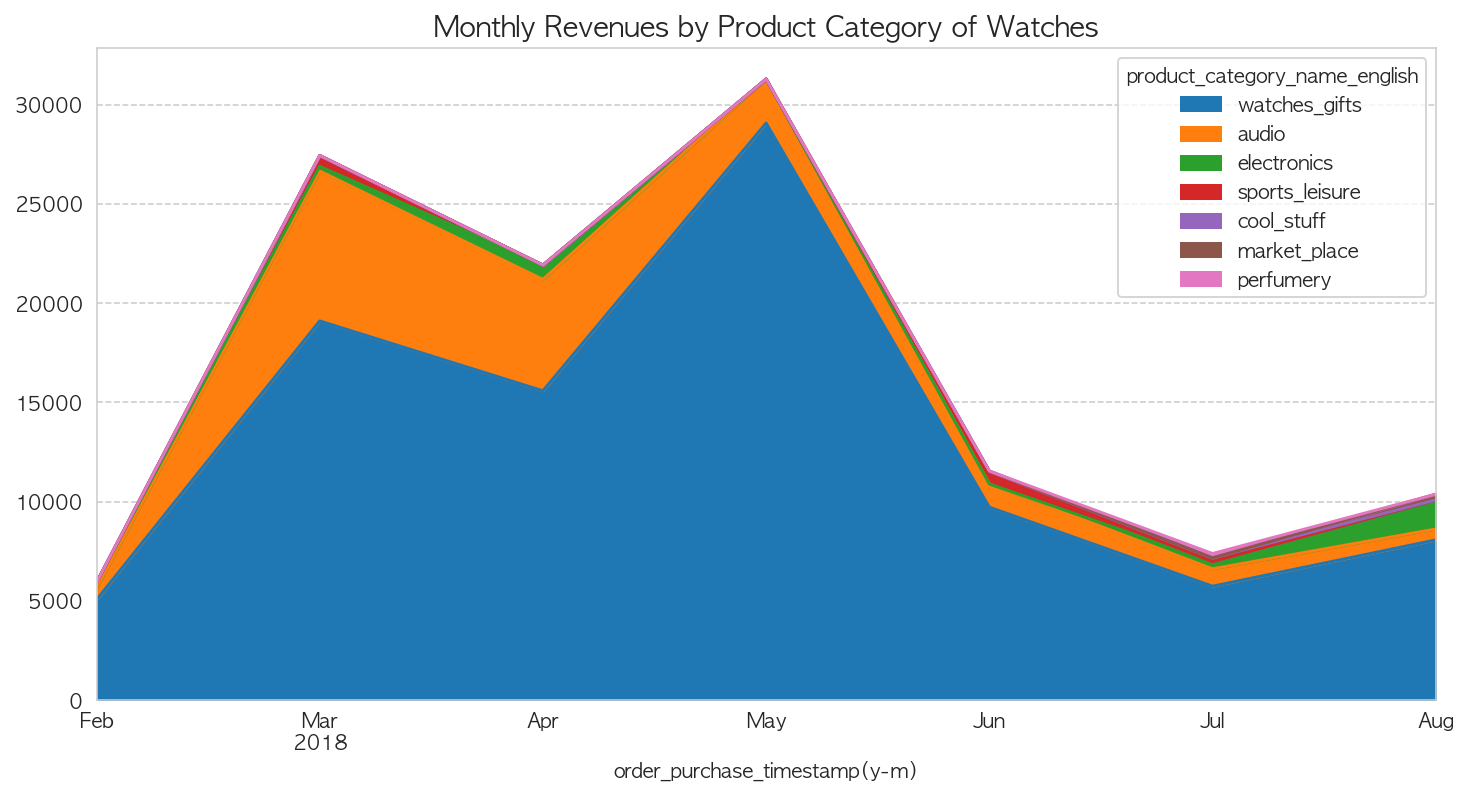

In [35]:
# Plot the monthly revenues by category
monthly_revenue_category.plot.area(figsize=(12,6))
plt.title('Monthly Revenues by Product Category of Watches', fontsize=14)

+ 'watches_gifts' category generated 79.7% of total revenue of segment.
+ 'watches_gifts' revenue soared in March and reached its peak in May. This category seems a seasonal item.

#### Watches Revenue by Seller

In [36]:
# Create 'seller - product category' table
cols = watches.groupby('product_category_name_english') \
              .price \
              .sum() \
              .sort_values(ascending=False) \
              .index

watches_seller_revenue = watches.pivot_table(index='seller_id',
                   columns='product_category_name_english',
                   values='price',
                   aggfunc='sum',
                   fill_value=0)

watches_seller_revenue = watches_seller_revenue[cols]

watches_seller_revenue.T

seller_id,7d13fca15225358621be4086e1eb0964,bce6a5ecf98e99fd2a8868b15c51f04b
product_category_name_english,,
watches_gifts,88919.28,3464.9
audio,18561.65,0.0
electronics,3074.65,0.0
sports_leisure,1013.00,0.0
cool_stuff,360.00,0.0
market_place,287.60,0.0
perfumery,220.00,0.0


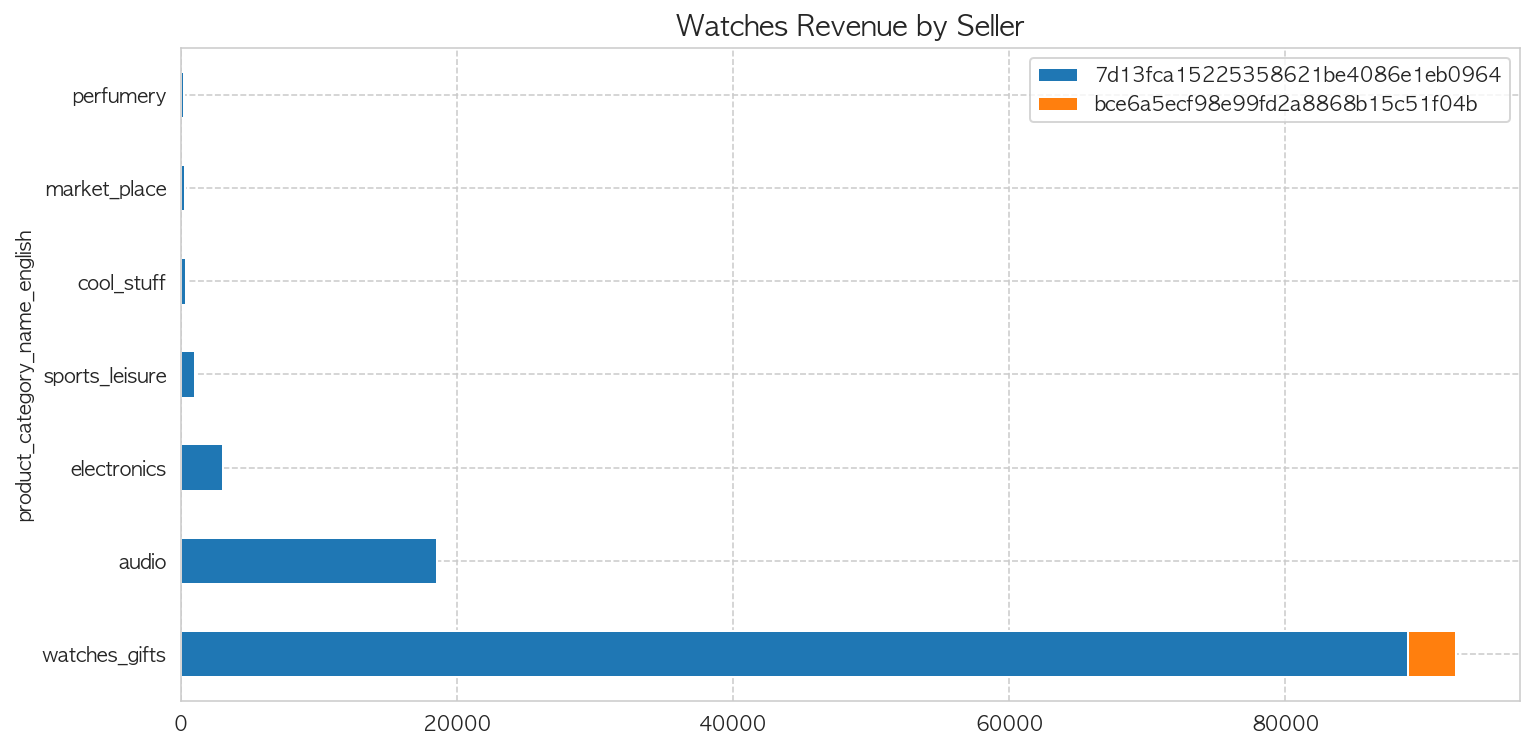

In [37]:
# Plot the above table
watches_seller_revenue.T.plot.barh(stacked=True, figsize=(12,6))

plt.title('Watches Revenue by Seller', fontsize=14)
plt.legend(loc='upper right');

+ Though 'watches' segment is the largest part of revenue, it has only two sellers.
+ Furthermore, the leading seller generated 97.0% of segment revenue.

#### Watches_gifts Revenue by Product

In [38]:
index = watches[watches['product_category_name_english'] == 'watches_gifts'] \
                .groupby('product_id') \
                .price \
                .sum() \
                .sort_values(ascending=False) \
                .index

product_seller_revenue = watches[watches['product_category_name_english'] == 'watches_gifts'] \
                                  .groupby(['seller_id', 'product_id']) \
                                  .price \
                                  .sum() \
                                  .unstack(level=0, fill_value=0)

product_seller_revenue = product_seller_revenue.reindex(index)
product_seller_revenue.head(3)

seller_id,7d13fca15225358621be4086e1eb0964,bce6a5ecf98e99fd2a8868b15c51f04b
product_id,,
53b36df67ebb7c41585e8d54d6772e08,22574.43,0.0
1a080577618e7fe4d9ddd8fb2b47a964,8567.99,0.0
6f3b5b605d91b7439c5e3f5a8dffeea7,6970.00,0.0


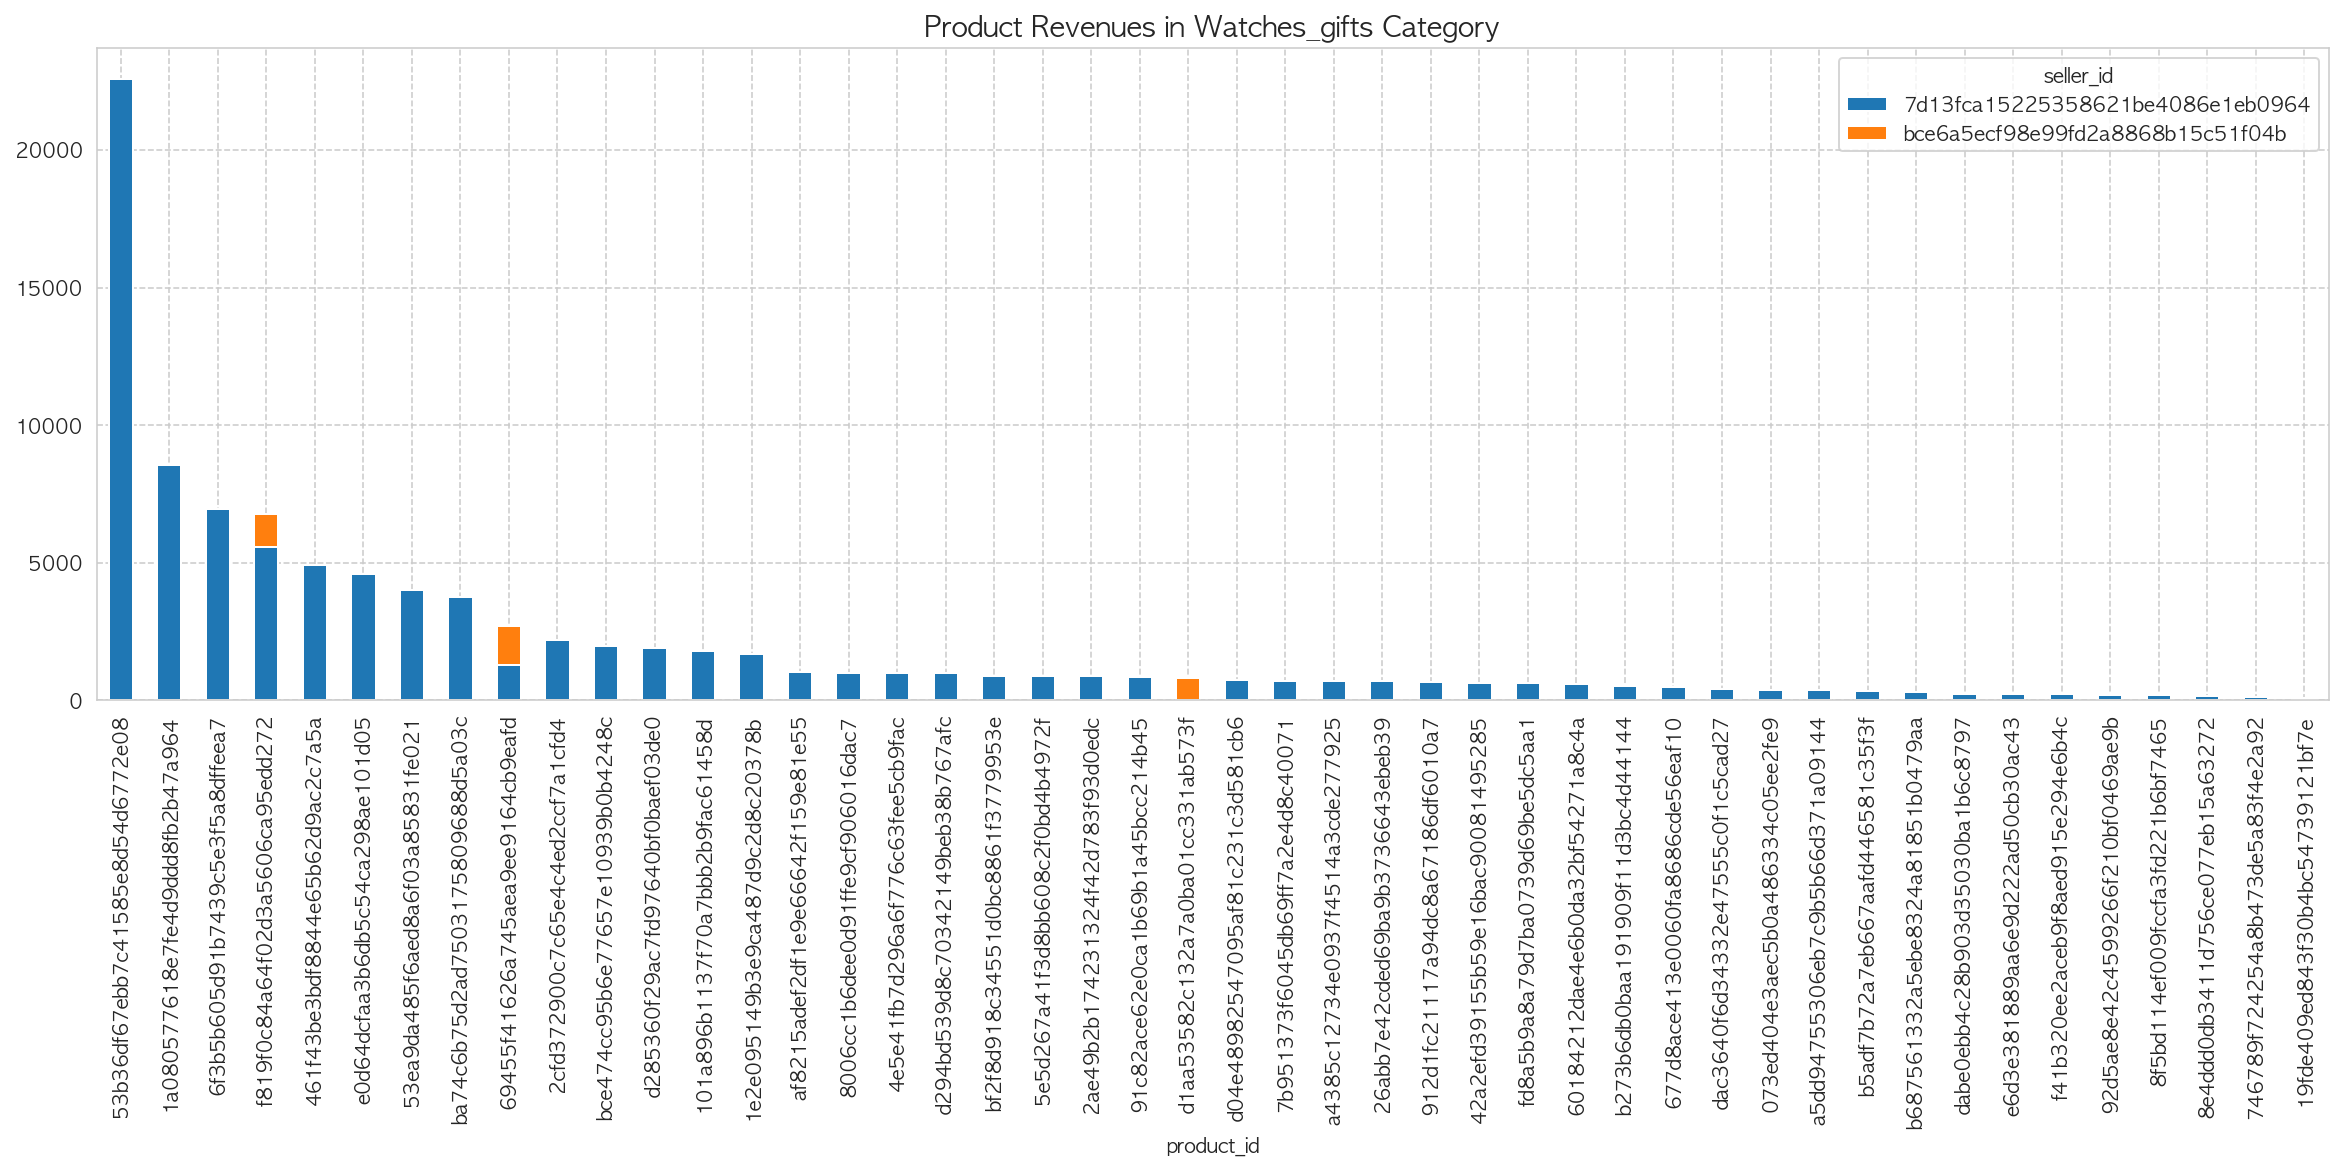

In [39]:
product_seller_revenue.plot.bar(stacked=True, figsize=(20, 6))
plt.title('Product Revenues in Watches_gifts Category', fontsize=14);

+ With 46 items in 'watches gifts' category, the top selling product accounts for 24.4% and five best-selling items form 53.9% of category revenue.
+ 'watches_gifts' may be a relatively homogeneous market so securing popular items is more important than pursuing a broad range of products. It implies that a category leader should be acquired to boost category revenue.